In [3]:
%matplotlib widget

import tensorflow as tf
from matplotlib import pyplot
import matplotlib
import matplotlib.cm as colormap
import numpy
import os
import json, pickle
import pandas
from functools import partial, reduce
import importlib
from sklearn import manifold
from scipy import stats

import sys
sys.path.append('../libs')

import flacdb
import prepare_data
import initialize
import data_pipeline
import conv_model
import plot_batch
import generate_report_kfold
import icd_util

pyplot.style.use('dark_background')

In [4]:
H, X0, Y0, P0, metadata, priors = generate_report_kfold.generate_predictions(
    model_id = 1469795,
    fold_index = 0,
    checkpoint_index = 2,
    example_count_log2 = 14
)

found hypes ../hypes/1469795_20200512-210303.json 
found weights /scr1/checkpoints/1469795_20200512-210303_00384.ckpt
loading predictions


In [5]:
H, X1, Y1, P1, metadata, priors = generate_report_kfold.generate_predictions(
    model_id = 1469816,
    fold_index = 1,
    checkpoint_index = 2,
    example_count_log2 = 14
)

found hypes ../hypes/1469816_20200512-213718.json 
found weights /scr1/checkpoints/1469816_20200512-213718_00384.ckpt
loading predictions


In [6]:
H, X2, Y2, P2, metadata, priors = generate_report_kfold.generate_predictions(
    model_id = 1470209,
    fold_index = 2,
    checkpoint_index = 2,
    example_count_log2 = 14
)

found hypes ../hypes/1470209_20200513-050523.json 
found weights /scr1/checkpoints/1470209_20200513-050523_00384.ckpt
loading predictions


In [7]:
P = numpy.vstack([P0, P1, P2])
Z = numpy.log(P / (1 - P))
X = {k: numpy.concatenate([X0[k], X1[k], X2[k]], axis=0) for k in X0}
Y = {k: numpy.concatenate([Y0[k], Y1[k], Y2[k]], axis=0) for k in Y0}

In [8]:
group_names = icd_util.load_group_strings()

def get_name(code):
    if code not in group_names:
        return code.replace('_', ' ').title()
    name = code + ': ' + group_names[code]
    name = name.replace('/', '_')
    for character in "',()[]":
        name = name.replace(character, '')
    return name

names = [get_name(i).strip() for i in priors.index]

In [54]:
# j = 0
j = next(i for i in range(len(names)) if 'pneu' in names[i].lower())
names[j]

'480-488: Pneumonia And Influenza'

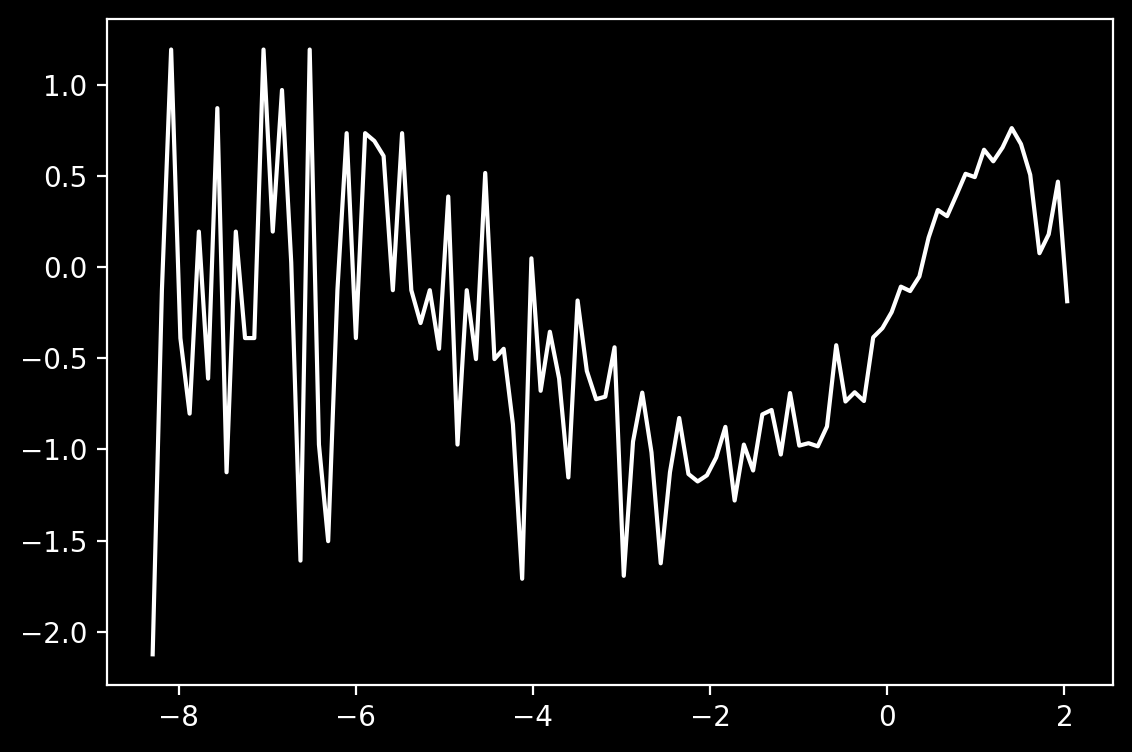

In [55]:
z = Z[:, j]
z = z.clip(*numpy.percentile(z, [0.1, 99.9]))
y = Y['diagnosis'][:, j]
counts_all, bins = numpy.histogram(z, bins=100)
counts_pos, _ = numpy.histogram(z[y == 1], bins=bins)
counts_neg, _ = numpy.histogram(z[y == -1], bins=bins)
q = (counts_pos + 1) / (counts_neg + counts_pos + 1)
prior = (y[y!=0] == 1).mean()
risk = numpy.log2(q / prior)
x = (bins[:-1] + bins[1:]) / 2
fig = pyplot.figure(0)
fig.clear()
pyplot.plot(x, risk, 'w')
fig

In [42]:
def gaussian(diff, sig):
    denominator = sig * numpy.sqrt(2*numpy.pi)
    exp_arg = - (diff**2) / (2 * sig**2)
    return numpy.exp(exp_arg) / denominator

from scipy import stats
mu, sig = numpy.random.rand(2) * 5
p1 = stats.norm(mu, sig).pdf(0)
p2 = gaussian(mu, sig)
assert(numpy.isclose(p1, p2))

In [56]:
%%time
bandwidth = 0.3
clip_percentile = 0.1
z = Z[:, j]
low, high = numpy.percentile(z, [clip_percentile, 100 - clip_percentile])
domain = numpy.linspace(low, high, 1000)
D = numpy.expand_dims(z, axis=1) - numpy.expand_dims(domain, axis=0)
D = gaussian(D, bandwidth)
density = D.sum(axis=0)
density /= density.sum() * (domain[1] - domain[0])
density_pos = D[y == 1].sum(axis=0)
density_neg = D[y == -1].sum(axis=0)

CPU times: user 1.22 s, sys: 26.7 s, total: 27.9 s
Wall time: 27.9 s


In [59]:
%matplotlib widget

In [60]:
fig = pyplot.figure(1)
fig.clear()
pyplot.plot(domain, density_neg, 'g')
pyplot.plot(domain, density_pos, 'r')
pyplot.ylabel('Count')
pyplot.xlabel('Prediction')
pyplot.title(names[j])
fig.canvas

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [61]:
prior = (y[y!=0] == 1).mean()
posterior = (density_pos + 1) / (density_neg + density_pos + 1)
risk = numpy.log2(posterior / prior)
fig = pyplot.figure(4)
fig.clear()
pyplot.plot(domain, risk)
pyplot.plot(domain, [-1] * len(domain), '--', color='blue')
pyplot.plot(domain, [1] * len(domain), '--', color='orange')

if risk.min() < -2:
    pyplot.plot(domain, [-2] * len(domain), '--', color='green')
    il2 = numpy.where(risk < -2)[0][-1]
    pyplot.plot(domain[il2], risk[il2], 'ow')

if risk.min() < -1:
    il1 = numpy.where(risk < -1)[0][-1]
    pyplot.plot(domain[il1], risk[il1], 'ow')
    
if risk.max() > 1:
    ih1 = numpy.where(risk > 1)[0][0]
    pyplot.plot(domain[ih1], risk[ih1], 'ow')
    
if risk.max() > 2:
    pyplot.plot(domain, [2] * len(domain), '--', color='red')
    ih2 = numpy.where(risk > 2)[0][0]
    pyplot.plot(domain[ih2], risk[ih2], 'ow')

pyplot.ylabel('Risk')
pyplot.xlabel('Prediction')
pyplot.title(names[j])
fig.canvas

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
fig = pyplot.figure(5)
fig.clear()
pyplot.plot(domain, density, 'w')

legend = ['PDF']

if risk.max() > 1:
    p_high = density[ih1:].sum() * (domain[1] - domain[0])
    pyplot.fill_between(domain[ih1:], density[ih1:], color='orange')
    legend.append('{}% High Risk'.format(int(round(p_high * 100))))
    
if risk.max() > 2:
    p_high2 = density[ih2:].sum() * (domain[1] - domain[0])
    pyplot.fill_between(domain[ih2:], density[ih2:], color='red')
    legend.append('{}% Very High Risk'.format(int(round(p_high2 * 100))))

if risk.min() < -1:
    p_low = density[:il1].sum() * (domain[1] - domain[0])
    pyplot.fill_between(domain[:il1], density[:il1], color='blue')
    legend.append('{}% Low Risk'.format(int(round(p_low * 100))))

if risk.min() < -2:
    p_low2 = density[:il2].sum() * (domain[1] - domain[0])
    pyplot.fill_between(domain[:il2], density[:il2], color='green')
    legend.append('{}% Very Low Risk'.format(int(round(p_low2 * 100))))

pyplot.legend(legend)
    
if risk.max() > 1:
    pyplot.plot([domain[ih1]]*2, [0, density[ih1]], '--w')
    
if risk.max() > 2:
    pyplot.plot([domain[ih2]]*2, [0, density[ih2]], '--w')

if risk.min() < -1:
    pyplot.plot([domain[il1]]*2, [0, density[il1]], '--w')

if risk.min() < -2:
    pyplot.plot([domain[il2]]*2, [0, density[il2]], '--w')
    
pyplot.ylabel('Probability Density')
pyplot.xlabel('Prediction')
pyplot.title(names[j])
fig.canvas

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
%matplotlib widget